# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [3]:
from datetime import date
from collections import Counter
from io import StringIO
import sqlite3

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Paso 2: Descargar HTML

In [4]:
url = "https://es.wikipedia.org/wiki/Anexo:Canciones_m%C3%A1s_reproducidas_en_Spotify"
respuesta = requests.get(url)
contenido_html = respuesta.text

## Paso 3: Transformar el HTML

In [6]:
tablas = pd.read_html(StringIO(contenido_html))
print(f"Número de tablas encontradas: {len(tablas)}")
df_raw = tablas[0]

Número de tablas encontradas: 16


## Paso 4: Procesar el DataFrame

In [7]:
df_raw.columns = ["Numero", "Canción", "Artista", "Álbum", "Millones de reproducciones", "Fecha de publicación"]
df = df_raw[["Canción", "Artista", "Millones de reproducciones", "Fecha de publicación"]].dropna()

df['Millones de reproducciones'] = df['Millones de reproducciones'].astype(str).str.replace('[^0-9.]', '', regex=True).astype(float)
df = df.dropna(subset=['Canción', 'Artista'])
df.reset_index(drop=True, inplace=True)
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('ó', 'o').str.replace('á', 'a')
df.insert(0, 'rank', df.index + 1)

df.head()

,rank,cancion,artista,millones_de_reproducciones,fecha_de_publicacion
0,1,Blinding Lights,The Weeknd,4786.0,9 de agosto de 2020
1,2,Shape of You,Ed Sheeran,4305.0,3 de marzo de 2017
2,3,Someone You Loved,Lewis Capaldi,3861.0,8 de noviembre de 2018
3,4,Starboy,"The Weeknd, Daft Punk",3833.0,21 de septiembre de 2016
4,5,As It Was,Harry Styles,3828.0,1 de abril de 2022


## Paso 5: Almacenar los datos en SQLite

In [8]:
df['fecha_scraping'] = hoy
conn = sqlite3.connect("spotify_diario.db")

df[['rank', 'cancion', 'artista', 'millones_de_reproducciones', 'fecha_de_publicacion', 'fecha_scraping']].to_sql(
    "ranking_diario", conn, if_exists="append", index=False
)
df_sql = pd.read_sql_query("SELECT * FROM ranking_diario", conn)
conn.close()

print("Datos almacenados exitosamente en la base de datos.")

Datos almacenados exitosamente en la base de datos.


## Paso 6: Visualizar los datos

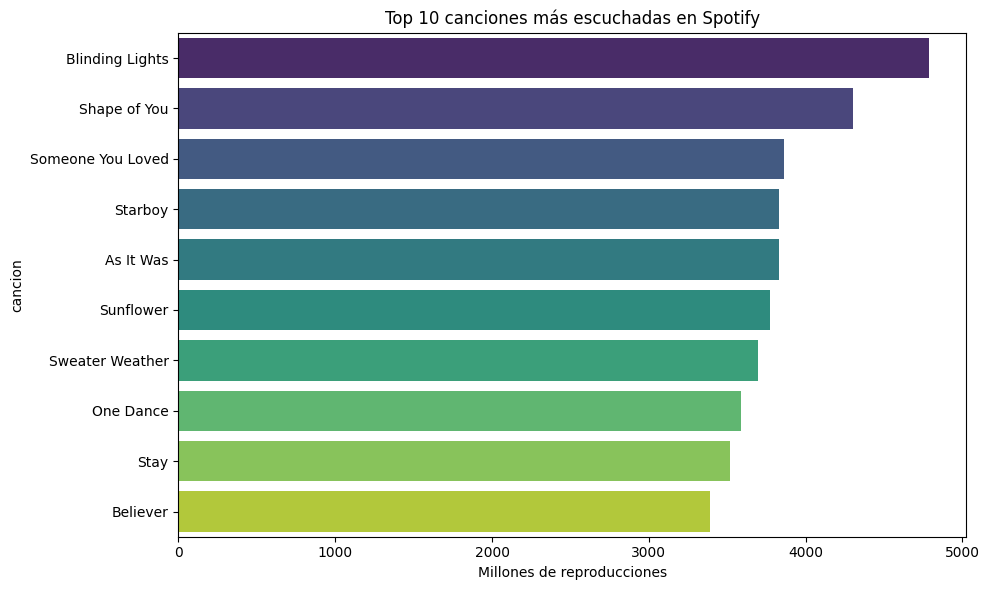

In [9]:
df_sql['millones_de_reproducciones'] = df_sql['millones_de_reproducciones'].astype(str).str.replace('[^0-9.]', '', regex=True).astype(float)
df_sql = df_sql[~df_sql['cancion'].str.contains("abril", case=False, na=False)]

top10 = df_sql.sort_values('millones_de_reproducciones', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top10, x="millones_de_reproducciones", y="cancion", hue="cancion", palette="viridis", legend=False)
#plt.barh(top10['cancion'][::-1], top10['millones_de_reproducciones'][::-1])
plt.xlabel('Millones de reproducciones')
plt.title('Top 10 canciones más escuchadas en Spotify')
plt.tight_layout()
plt.show()

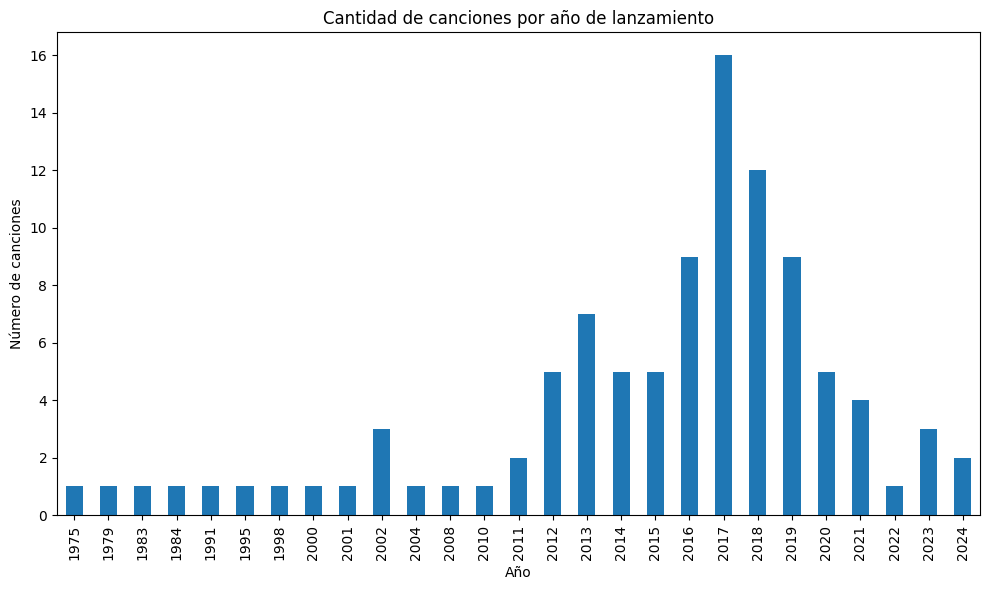

In [10]:
df_sql['fecha_de_publicacion'] = df_sql['fecha_de_publicacion'].astype(str).str.extract(r'(\d{4})').astype(float)
df_sql = df_sql.dropna(subset=['fecha_de_publicacion'])

df_sql['fecha_de_publicacion'] = df_sql['fecha_de_publicacion'].astype(int)
df_sql['fecha_de_publicacion'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))

plt.title('Cantidad de canciones por año de lanzamiento')
plt.xlabel('Año')
plt.ylabel('Número de canciones')
plt.tight_layout()
plt.show()

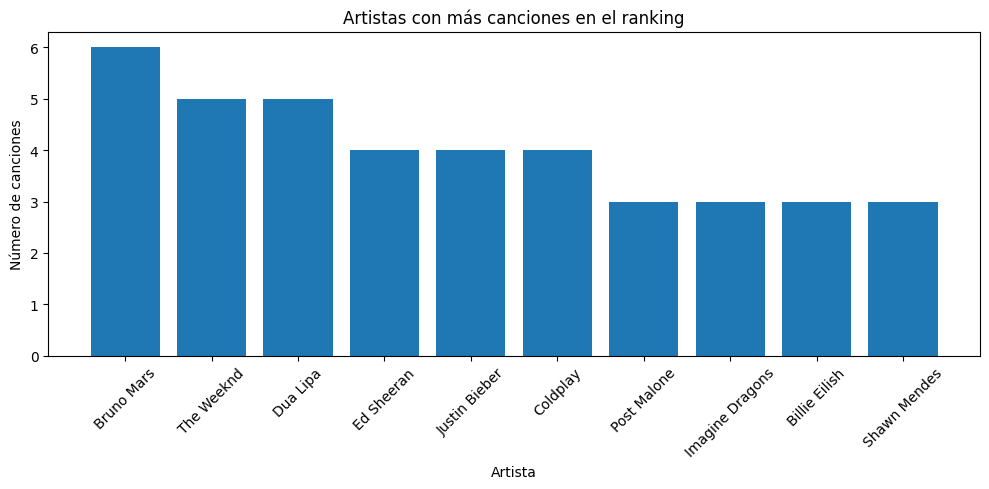

In [11]:
df_sql['artista'] = df_sql['artista'].astype(str)
artistas_separados = df_sql['artista'].str.split(r',| and ')
todos = [a.strip() for sublist in artistas_separados for a in sublist]

conteo = Counter(todos)
top_artistas = dict(sorted(conteo.items(), key=lambda x: x[1], reverse=True)[:10])

plt.figure(figsize=(10, 5))
plt.bar(top_artistas.keys(), top_artistas.values())
plt.title('Artistas con más canciones en el ranking')
plt.xlabel('Artista')
plt.ylabel('Número de canciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()